In [48]:
# GPU info, check if tensorflow is using the GPU
import tensorflow as tf
import pynvml
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU")
    
    # Initialize the pynvml library
    pynvml.nvmlInit()
    
    # Get the number of GPU devices
    num_gpus = pynvml.nvmlDeviceGetCount()
    
    # Iterate over GPU devices
    for i in range(num_gpus):
        # Get the device identifier
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        # Get the full GPU name
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)
        
    # Shutdown the pynvml library
    pynvml.nvmlShutdown()
else:
    print("TensorFlow is not using the GPU")

TensorFlow is using the GPU
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
# GPU info
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
# set GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    # This code retrieves the available GPU and enables memory growth for dynamic allocation, potentially improving
    # memory usage.
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPUs available.")

In [1]:
# Importing required libraries
import os
import cv2 as cv
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Dense, SeparableConv2D, MaxPooling2D, Flatten, Dropout, Activation

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
# This code retrieves the available GPU and enables memory growth for dynamic allocation, potentially improving
# memory usage.
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Hyperparameters
INIT_LR = 0.1
NUM_EPOCH = 50
BATCH_SIZE = 64
lr_find = True

In [4]:
# Initialize lists to store images and labels
images = []
labels = []

# Define classes
classes = ['Not_Fire', 'Fire']

In [5]:
# Iterate through each class folder to load images
for c in classes:
    try:
        img_folder = 'Image_Dataset/' + c
        print(f'Currently Processing Path : {img_folder}')
        jpg_imgs = glob(f'{img_folder}/*.jpg')
        for img in jpg_imgs:
            img = cv.imread(str(img))
            if img is not None:
                img = cv.resize(img, (128, 128))
                images.append(img)
                labels.append(1 if c == 'Fire' else 0)
            else:
                os.remove(imgPath)
                print(f'file deleted: {imgPath}')
    except Exception as e:
        print(f'Error in creating dataset : {e}')

print('created dataset of images and labels.')

Currently Processing Path : Image_Dataset/Not_Fire
Currently Processing Path : Image_Dataset/Fire
created dataset of images and labels.


In [7]:
# check random image
random_img = np.random.randint(0, len(images))
cv.imshow(str(labels[random_img]), images[random_img])
cv.waitKey(0)
cv.destroyAllWindows()

In [8]:
# Convert images and labels to numpy arrays
images = np.array(images, dtype='float32') / 255.
labels = np.array(labels)
labels = np_utils.to_categorical(labels, num_classes=2)

In [9]:
# Calculate class weights
d = {}
classTotals = labels.sum(axis=0)
print(classTotals)
classWeight = classTotals.max() / classTotals
print(classWeight)
d[0] = classWeight[0]
d[1] = classWeight[1]
print(f'd : {d}')

[2705.  786.]
[1.        3.4414759]
d : {0: 1.0, 1: 3.4414759}


In [10]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.25, shuffle=True, random_state=42)

In [46]:
# Data Augmentation
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [47]:
# In case of multi-GPU devices memory growth should be constant through out all available GPUs. Either set it true for all GPUs or keep it false.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [49]:
# Initialize model
model = Sequential()

# Add layers to the model
model.add(SeparableConv2D(16, (7,7), padding='same', input_shape=(128, 128,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(SeparableConv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(SeparableConv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(classes)))
model.add(Activation('softmax'))

# Define optimizer
opt = SGD(learning_rate=INIT_LR, momentum=0.8, decay=INIT_LR / NUM_EPOCH)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 128, 128, 16)     211       
 Conv2D)                                                         
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 64, 64, 32)       688       
 leConv2D)                                              

In [50]:
# Train the model
print('[INFO] training network...')

H = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
             validation_data=(X_test, y_test),
             steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
             epochs=NUM_EPOCH,
             class_weight=d,
             verbose=1
             )
print("[INFO] serializing network to '{}'...".format('output/model'))


[INFO] training network...
Epoch 1/50
40/40 [==============================] - 12s 232ms/step - loss: 0.9173 - accuracy: 0.7388 - val_loss: 8.6465 - val_accuracy: 0.3883
Epoch 2/50
40/40 [==============================] - 8s 203ms/step - loss: 0.6731 - accuracy: 0.8183 - val_loss: 1.1396 - val_accuracy: 0.8580
Epoch 3/50
40/40 [==============================] - 8s 203ms/step - loss: 0.6603 - accuracy: 0.8273 - val_loss: 0.8155 - val_accuracy: 0.7835
Epoch 4/50
40/40 [==============================] - 8s 187ms/step - loss: 0.5924 - accuracy: 0.8285 - val_loss: 0.6008 - val_accuracy: 0.8225
Epoch 5/50
40/40 [==============================] - 8s 207ms/step - loss: 0.5909 - accuracy: 0.8383 - val_loss: 0.6138 - val_accuracy: 0.7365
Epoch 6/50
40/40 [==============================] - 8s 195ms/step - loss: 0.5609 - accuracy: 0.8430 - val_loss: 0.4330 - val_accuracy: 0.8534
Epoch 7/50
40/40 [==============================] - 15s 389ms/step - loss: 0.5232 - accuracy: 0.8528 - val_loss: 0.4259 

In [53]:
# Save the model
model.save('output/fire_detection1.h5')

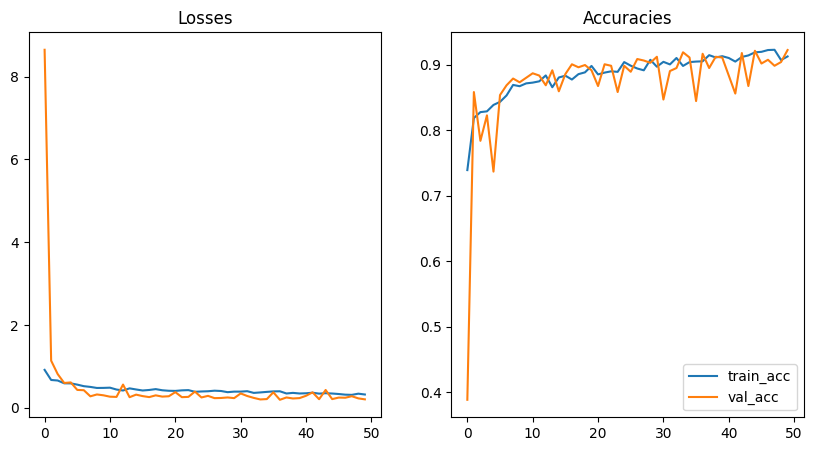

In [54]:
# Plot training history
N = np.arange(0, NUM_EPOCH)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Losses')
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')

plt.subplot(122)
plt.title('Accuracies')
plt.plot(N, H.history['accuracy'], label='train_acc')
plt.plot(N, H.history['val_accuracy'], label='val_acc')


plt.legend()
plt.savefig("output/training_plot.png")

In [1]:
# Load the saved model
try:
    print('[INFO loading model...]')
    model = load_model('output/fire_detection1.h5')
    print('[INFO model loaded successfully...]')
except Exception as e:
    print(f'ERROR : {e}')

[INFO loading model...]
ERROR : name 'load_model' is not defined


In [ ]:
# Perform inference on test images and plot predictions
plt.figure(figsize=(15, 10))
for i in range(1, 11):  # Plot 10 images
    random_index = np.random.randint(0, len(X_test))
    org_img = X_test[random_index] * 255

    img = org_img.copy()
    img = cv.resize(img, (128, 128))
    img = img.astype('float32') / 256

    pred = model.predict(np.expand_dims(img, axis=0))[0]
    result = classes[np.argmax(pred)]

    org_img = cv.resize(org_img, (300, 300))
    cv.rectangle(org_img, (0, 20), (200, 55), (255, 255, 255), -1)
    cv.putText(org_img, result, (35,50), cv.FONT_HERSHEY_SIMPLEX, 1.25, (0, 0, 0), 2)
    cv.imwrite('output/testing/{}.png'.format(i),org_img)
    
    plt.subplot(2, 5, i)
    plt.imshow(cv.cvtColor(org_img, cv.COLOR_BGR2RGB))
    plt.title(f'Prediction: {result}')
    plt.axis('off')

plt.tight_layout()
plt.show()
